In [ ]:
!pip install yfinance
!pip install finta
!pip install schedule
!pip install line-bot-sdk
!pip install flask_ngrok
!pip install colorama

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.6/730.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 5.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/ChatGPT-AI-InvestmentAdvisor/')

Mounted at /content/drive


[*********************100%%**********************]  1 of 1 completed


100%|██████████| 67/67 [00:00<00:00, 1092.97it/s]


3/3 [==============================] - 0s 18ms/step


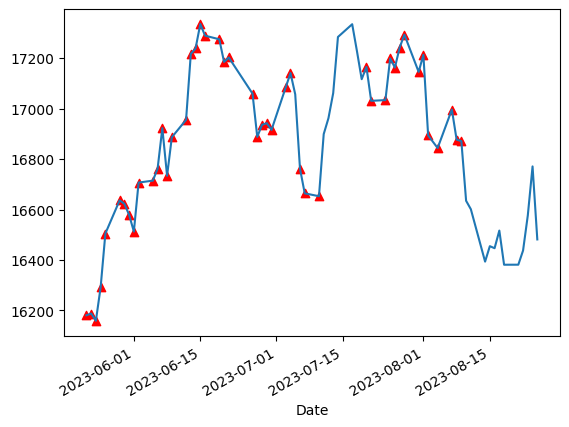

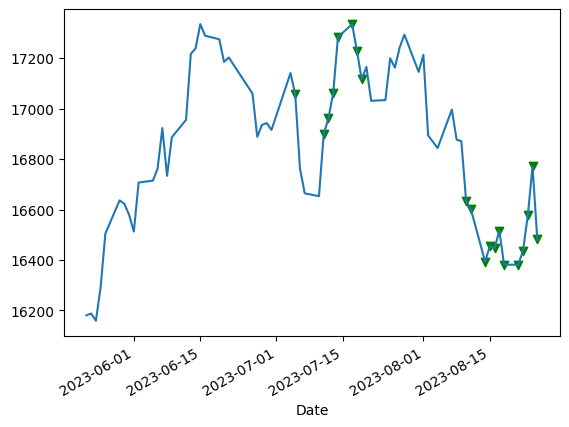

第1次交易:
買入時間: 2023-03-01 00:00:00
買入價格: 15598.490234375
{'ok': True, 'result': {'message_id': 740, 'from': {'id': 6408668931, 'is_bot': True, 'first_name': 'b093040053_bot', 'username': 'tzushan_bot'}, 'chat': {'id': 1238268545, 'first_name': 'Tzu-shan', 'last_name': 'Chang', 'username': 'tzushan_tsubasa', 'type': 'private'}, 'date': 1693213661, 'text': '第1次交易:'}}
{'ok': True, 'result': {'message_id': 741, 'from': {'id': 6408668931, 'is_bot': True, 'first_name': 'b093040053_bot', 'username': 'tzushan_bot'}, 'chat': {'id': 1238268545, 'first_name': 'Tzu-shan', 'last_name': 'Chang', 'username': 'tzushan_tsubasa', 'type': 'private'}, 'date': 1693213662, 'text': '現在時間:2023-03-01,  投資項目:^TWII,  當前建議操作:建議買入'}}
{'ok': True, 'result': {'message_id': 742, 'from': {'id': 6408668931, 'is_bot': True, 'first_name': 'b093040053_bot', 'username': 'tzushan_bot'}, 'chat': {'id': 1238268545, 'first_name': 'Tzu-shan', 'last_name': 'Chang', 'username': 'tzushan_tsubasa', 'type': 'private'}, 'date': 1693213

In [ ]:
#此份檔案程式碼主要架構參考自chatgpt:https://sharegpt.com/c/kZOYTX1
'''
幫我寫一個程式功能如下:
有一個函數叫send_to_telegram(message)用來發送message
有一個函數叫process(df,min_max_scaler,model)用來根據輸入的參數產生交易信號
有一個函數叫main()此做幾件事情:
1.載入model.h5模型
2.載入scaler.pkl
3.使用yfinance取得最近180天^TWII資料稱為df
4.套用process(df,min_max_scaler,model)取得signal
5.當signal == 0,send_to_telegram('不動作')
6.當signal == 1,send_to_telegram('買進')
7.當signal == 2,send_to_telegram('賣出')

使用schedule套件讓這個程式每天早上8點執行一次
'''
import yfinance as yf
from finta import TA
from keras.models import load_model
import pickle
import datetime as dt
import requests, json
import schedule
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorama
from colorama import Fore, Style

# 發電報函數
def send_to_telegram(message):
    apiToken = '6408668931:AAG6agBmOUCoBnVZ2zo8U7GvLHwP6metK0o'
    chatID = ['1238268545']
    #'6115245736'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'
    for i in range(len(chatID)):
      try:
          response = requests.post(apiURL, json={'chat_id': chatID[i], 'text': message})
          text = response.json()
          print(text)
      except Exception as e:
          print(e)

# 計算金融技術指標函數
def calculate_ta(df):
    ta_functions = [TA.SMA, TA.EMA, TA.STOCH, TA.TEMA, TA.STOCHD, TA.RSI, TA.STOCHRSI, TA.OBV, TA.MACD, TA.PPO, TA.ROC, TA.DMI, TA.ADX, TA.ATR, TA.MOM]
    ta_names = ['SMA','EMA','K','TEMA','D','RSI','STOCHRSI','OBV','MACD','PPO','ROC','DMI','ADX','ATR','MOM']
    for i, ta_func in enumerate(ta_functions):
        try:
            df[ta_names[i]] = ta_func(df)
        except:
            if ta_names[i] == 'MACD':
                df[ta_names[i]] = ta_func(df)['MACD']-ta_func(df)['SIGNAL']
            if ta_names[i] == 'PPO':
                df[ta_names[i]] = ta_func(df)['PPO']-ta_func(df)['SIGNAL']
            if ta_names[i] == 'DMI':
                df[ta_names[i]] = ta_func(df)['DI+']-ta_func(df)['DI-']
    return df

# 給定歷史數據,scaler,model,輸出買賣訊號的函數
def process(df,min_max_scaler,model):
    df = calculate_ta(df)
    df = df.dropna(axis=0)
    features = ['SMA','EMA','K','TEMA','D','RSI','STOCHRSI','OBV','MACD','PPO','ROC','DMI','ADX','ATR','MOM']
    Close = df[['Close']]
    df = df[features]
    # 數據轉換
    df[features] = min_max_scaler.transform(df[features])
    # 製作X(15x15's array)
    days = 15
    start_index = 0
    end_index = len(df)-days
    Xs = []
    indexs = []
    for i in tqdm(range(start_index ,end_index+1 ,1)):
        X = df.iloc[i:i+days,:][features]
        X = np.array(X)
        Xs.append(X)
        indexs.append((df.iloc[[i]].index,df.iloc[[i+days-1]].index))
    Xs = np.array(Xs)
    # 模型預測買賣訊號
    singal = model.predict(Xs)
    singal = [ np.argmax(i) for i in singal]

    # 繪圖
    Close = Close.iloc[-len(Xs):,:]
    Close['SIGNAL'] = singal
    buy = Close[Close['SIGNAL']==1]['Close']
    sell = Close[Close['SIGNAL']==2]['Close']

    Close['Close'].plot()
    plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
    plt.show()

    Close['Close'].plot()
    plt.scatter(list(sell.index),list(sell.values),color='green',marker='v')
    plt.show()

    return singal, Close.index

def main():
    # 載入模型和scaler
    model = load_model('/content/drive/MyDrive/ChatGPT-AI-InvestmentAdvisor/model_2_2.h5')
    with open('/content/drive/MyDrive/ChatGPT-AI-InvestmentAdvisor/scaler2_2.pkl', 'rb') as f:
        min_max_scaler = pickle.load(f)
    # 資料時間範圍設定
    start_date = (dt.datetime.now() - dt.timedelta(days=180)).strftime("%Y-%m-%d")
    end_date = dt.datetime.now().strftime("%Y-%m-%d")
    symbol = '^TWII'
    df = yf.download(symbol, start=start_date, end=end_date)
    df2 = df.reset_index()
    df2['Date'] = pd.to_datetime(df2['Date'])
    date = df2['Date']
    # 取得交易訊號
    signals, index = process(df,min_max_scaler,model)
    signal = signals[-1]
    if signal == 0:
        action = '不動作'
    if signal == 1:
        action = '建議買入'
    if signal == 2:
        action = '建議賣出'

    capital = 1000000  # 初始資本
    hold = False  # 是否持有股票
    entry_price = 0  # 進場價格
    entry_idx = 0  # 進場時間點
    exit_price = 0  # 出場價格
    exit_idx = 0  # 出場時間點
    t = 20
    lb = 0.97
    ub = 1.03
    capital_history = []
    n = 0
    temp = 0
    for i, signal in enumerate(signals):
        if signal == 1 and not hold:  # 進場買入
            hold = True
            entry_price = df.iloc[i]['Close']
            entry_idx = i
            n += 1
            print(f'第{n}次交易:')
            print('買入時間:', df.index[entry_idx])
            print('買入價格:', entry_price)
            # 發送消息至telegram
            if signal == 0:
              action = '不動作'
            if signal == 1:
              action = '建議買入'
            if signal == 2:
              action = '建議賣出'
            #current_time = dt.datetime.now().strftime("%Y-%m-%d")
            title = f'第{n}次交易:'
            send_to_telegram(title)
            current_time = df2.iloc[i]['Date'].strftime("%Y-%m-%d")
            message = f"現在時間:{current_time},  投資項目:{symbol},  當前建議操作:{action}"
            send_to_telegram(message)
            buy = df.index[entry_idx].strftime("%Y-%m-%d")
            message2 = f"買入時間:{buy} 買入價格:{entry_price}"
            send_to_telegram(message2)

            # 發送消息至line
            access_token = 'Bearer c6Zhd7ahP1ef5rjhTjzkUV093RI+d3MWfg0+yoyM9Xj712a6HG31U1ftXIYS9Bun1SAfos1VgpuMTLmoI7ngMQKrkLqLm6XE7eYr8qqZxn5LvgJ1VIKBqkxDRLi/KYoDgrsKZoPEH2KSqsbqoro0/AdB04t89/1O/w1cDnyilFU='
            secret = '4c64ab99437ed50529c461dc95bf8b95'

            # 注意前方要有 Bearer
            headers = {'Authorization': access_token,'Content-Type':'application/json'}
            body = {
                'to':'U7d64ff0c6e3ddda37825a7d2e5bbc53c',
                'messages':[{
                        'type': 'text',
                        'text': title,
                    }]
                }
            # 向指定網址發送 request
            req = requests.request('POST', 'https://api.line.me/v2/bot/message/push',headers=headers,data=json.dumps(body).encode('utf-8'))

            # 注意前方要有 Bearer
            headers = {'Authorization': access_token,'Content-Type':'application/json'}
            body = {
                'to':'U7d64ff0c6e3ddda37825a7d2e5bbc53c',
                'messages':[{
                        'type': 'text',
                        'text': message,
                    }]
                }
            # 向指定網址發送 request
            req = requests.request('POST', 'https://api.line.me/v2/bot/message/push',headers=headers,data=json.dumps(body).encode('utf-8'))

            body = {
                'to':'U7d64ff0c6e3ddda37825a7d2e5bbc53c',
                'messages':[{
                        'type': 'text',
                        'text': message2,
                    }]
                }
            # 向指定網址發送 request
            req = requests.request('POST', 'https://api.line.me/v2/bot/message/push',headers=headers,data=json.dumps(body).encode('utf-8'))
            temp = 0
            time.sleep(10)
        elif signal == 2 and hold:  # 出場賣出
            hold = False
            exit_price = df.iloc[i]['Close']
            exit_idx = i
            # 計算交易結果
            shares = capital // entry_price
            profit = shares * (exit_price - entry_price)
            capital += profit
            n += 1
            print(f'第{n}次交易:')
            print('賣出時間:', df.index[exit_idx])
            print('賣出價格:', exit_price)
            print('獲利:', profit)
            # 發送消息至telegram
            if signal == 0:
              action = '不動作'
            if signal == 1:
              action = '建議買入'
            if signal == 2:
              action = '建議賣出'
            #current_time = dt.datetime.now().strftime("%Y-%m-%d")
            title = f'第{n}次交易:'
            send_to_telegram(title)
            current_time = df2.iloc[i]['Date'].strftime("%Y-%m-%d")

            message = f"現在時間:{current_time},  投資項目:{symbol},  當前建議操作:{action}"
            send_to_telegram(message)
            sell = df.index[exit_idx].strftime("%Y-%m-%d")
            message3 = f"賣出時間:{sell} 賣出價格:{exit_price}"
            send_to_telegram(message3)
            buy = df.index[entry_idx].strftime("%Y-%m-%d")
            message2 = f"之前買入時間:{buy} 買入價格:{entry_price}"
            send_to_telegram(message2)
            message4 = f"獲利:{profit}"
            send_to_telegram(message4)

            # 發送消息至line
            access_token = 'Bearer c6Zhd7ahP1ef5rjhTjzkUV093RI+d3MWfg0+yoyM9Xj712a6HG31U1ftXIYS9Bun1SAfos1VgpuMTLmoI7ngMQKrkLqLm6XE7eYr8qqZxn5LvgJ1VIKBqkxDRLi/KYoDgrsKZoPEH2KSqsbqoro0/AdB04t89/1O/w1cDnyilFU='
            secret = '4c64ab99437ed50529c461dc95bf8b95'

            # 注意前方要有 Bearer
            headers = {'Authorization': access_token,'Content-Type':'application/json'}
            body = {
                'to':'U7d64ff0c6e3ddda37825a7d2e5bbc53c',
                'messages':[{
                        'type': 'text',
                        'text': title,
                    }]
                }
            # 向指定網址發送 request
            req = requests.request('POST', 'https://api.line.me/v2/bot/message/push',headers=headers,data=json.dumps(body).encode('utf-8'))

            # 注意前方要有 Bearer
            headers = {'Authorization': access_token,'Content-Type':'application/json'}
            body = {
                'to':'U7d64ff0c6e3ddda37825a7d2e5bbc53c',
                'messages':[{
                        'type': 'text',
                        'text': message,
                    }]
                }
            # 向指定網址發送 request
            req = requests.request('POST', 'https://api.line.me/v2/bot/message/push',headers=headers,data=json.dumps(body).encode('utf-8'))

            body = {
                'to':'U7d64ff0c6e3ddda37825a7d2e5bbc53c',
                'messages':[{
                        'type': 'text',
                        'text': message3,
                    }]
                }
            # 向指定網址發送 request
            req = requests.request('POST', 'https://api.line.me/v2/bot/message/push',headers=headers,data=json.dumps(body).encode('utf-8'))

            body = {
                'to':'U7d64ff0c6e3ddda37825a7d2e5bbc53c',
                'messages':[{
                        'type': 'text',
                        'text': message2,
                    }]
                }
            # 向指定網址發送 request
            req = requests.request('POST', 'https://api.line.me/v2/bot/message/push',headers=headers,data=json.dumps(body).encode('utf-8'))

            body = {
                'to':'U7d64ff0c6e3ddda37825a7d2e5bbc53c',
                'messages':[{
                        'type': 'text',
                        'text': message4,
                    }]
                }
            # 向指定網址發送 request
            req = requests.request('POST', 'https://api.line.me/v2/bot/message/push',headers=headers,data=json.dumps(body).encode('utf-8'))

            temp = 1
            time.sleep(10)
        elif hold and (i - entry_idx >= t or df.iloc[i]['Close'] <= entry_price * lb or df.iloc[i]['Close'] >= entry_price * ub):  # 到達出場條件
            hold = False
            exit_price = df.iloc[i]['Close']
            exit_idx = i
            # 計算交易結果
            shares = capital // entry_price
            profit = shares * (exit_price - entry_price)
            capital += profit
            n += 1
            print(f'第{n}次交易:')
            print('賣出時間:', df.index[exit_idx])
            print('賣出價格:', exit_price)
            print('獲利:', profit)
            # 發送消息至telegram
            action = '建議賣出'
            #current_time = dt.datetime.now().strftime("%Y-%m-%d")
            title = f'第{n}次交易:'
            send_to_telegram(title)
            current_time = df2.iloc[i]['Date'].strftime("%Y-%m-%d")
            message = f"現在時間:{current_time},  投資項目:{symbol},  當前建議操作:{action}"
            send_to_telegram(message)
            sell = df.index[exit_idx].strftime("%Y-%m-%d")
            message3 = f"賣出時間:{sell} 賣出價格:{exit_price}"
            send_to_telegram(message3)
            buy = df.index[entry_idx].strftime("%Y-%m-%d")
            message2 = f"之前買入時間:{buy} 買入價格:{entry_price}"
            send_to_telegram(message2)
            message4 = f"獲利:{profit}"
            send_to_telegram(message4)

            # 發送消息至line
            access_token = 'Bearer c6Zhd7ahP1ef5rjhTjzkUV093RI+d3MWfg0+yoyM9Xj712a6HG31U1ftXIYS9Bun1SAfos1VgpuMTLmoI7ngMQKrkLqLm6XE7eYr8qqZxn5LvgJ1VIKBqkxDRLi/KYoDgrsKZoPEH2KSqsbqoro0/AdB04t89/1O/w1cDnyilFU='
            secret = '4c64ab99437ed50529c461dc95bf8b95'

            # 注意前方要有 Bearer
            headers = {'Authorization': access_token,'Content-Type':'application/json'}
            body = {
                'to':'U7d64ff0c6e3ddda37825a7d2e5bbc53c',
                'messages':[{
                        'type': 'text',
                        'text': title,
                    }]
                }
            # 向指定網址發送 request
            req = requests.request('POST', 'https://api.line.me/v2/bot/message/push',headers=headers,data=json.dumps(body).encode('utf-8'))

            # 注意前方要有 Bearer
            headers = {'Authorization': access_token,'Content-Type':'application/json'}
            body = {
                'to':'U7d64ff0c6e3ddda37825a7d2e5bbc53c',
                'messages':[{
                        'type': 'text',
                        'text': message,
                    }]
                }
            # 向指定網址發送 request
            req = requests.request('POST', 'https://api.line.me/v2/bot/message/push',headers=headers,data=json.dumps(body).encode('utf-8'))

            body = {
                'to':'U7d64ff0c6e3ddda37825a7d2e5bbc53c',
                'messages':[{
                        'type': 'text',
                        'text': message3,
                    }]
                }
            # 向指定網址發送 request
            req = requests.request('POST', 'https://api.line.me/v2/bot/message/push',headers=headers,data=json.dumps(body).encode('utf-8'))

            body = {
                'to':'U7d64ff0c6e3ddda37825a7d2e5bbc53c',
                'messages':[{
                        'type': 'text',
                        'text': message2,
                    }]
                }
            # 向指定網址發送 request
            req = requests.request('POST', 'https://api.line.me/v2/bot/message/push',headers=headers,data=json.dumps(body).encode('utf-8'))

            body = {
                'to':'U7d64ff0c6e3ddda37825a7d2e5bbc53c',
                'messages':[{
                        'type': 'text',
                        'text': message4,
                    }]
                }
            # 向指定網址發送 request
            req = requests.request('POST', 'https://api.line.me/v2/bot/message/push',headers=headers,data=json.dumps(body).encode('utf-8'))
            temp = 1
            time.sleep(10)
        capital_history.append(capital)
        if temp == 1:
          message5 = f"目前累積報酬率:+{(capital_history[-1]/capital_history[0]-1)*100:0.3f}% 目前最大虧損:{-(1-min(capital_history)/capital_history[0])*100:0.3f}%"
          send_to_telegram(message5)
          temp = 0

          # 發送消息至line
          access_token = 'Bearer c6Zhd7ahP1ef5rjhTjzkUV093RI+d3MWfg0+yoyM9Xj712a6HG31U1ftXIYS9Bun1SAfos1VgpuMTLmoI7ngMQKrkLqLm6XE7eYr8qqZxn5LvgJ1VIKBqkxDRLi/KYoDgrsKZoPEH2KSqsbqoro0/AdB04t89/1O/w1cDnyilFU='
          secret = '4c64ab99437ed50529c461dc95bf8b95'

          # 注意前方要有 Bearer
          headers = {'Authorization': access_token,'Content-Type':'application/json'}
          body = {
                'to':'U7d64ff0c6e3ddda37825a7d2e5bbc53c',
                'messages':[{
                        'type': 'text',
                        'text': message5,
                    }]
                }
          # 向指定網址發送 request
          req = requests.request('POST', 'https://api.line.me/v2/bot/message/push',headers=headers,data=json.dumps(body).encode('utf-8'))
          time.sleep(10)


if __name__ == '__main__':
    main()
    # 如果你有local python環境或是上雲端python環境可以使用以下代碼讓他定時執行main()函數
    #schedule.every().day.at('08:00').do(main)#每日八點準時執行
    #while True:
    #    schedule.run_pending()
    #    time.sleep(1)

[*********************100%%**********************]  1 of 1 completed


100%|██████████| 65/65 [00:00<00:00, 1703.69it/s]

3/3 [==============================] - 0s 11ms/step


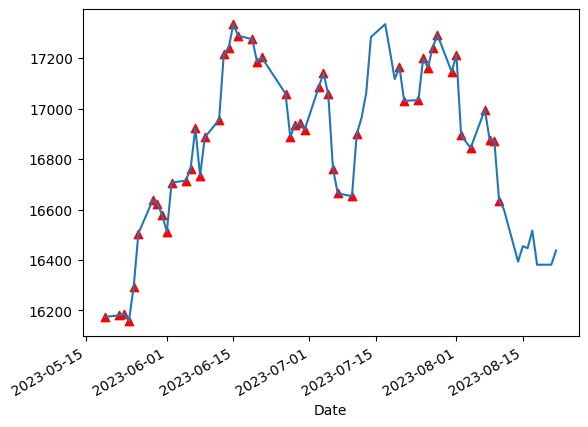

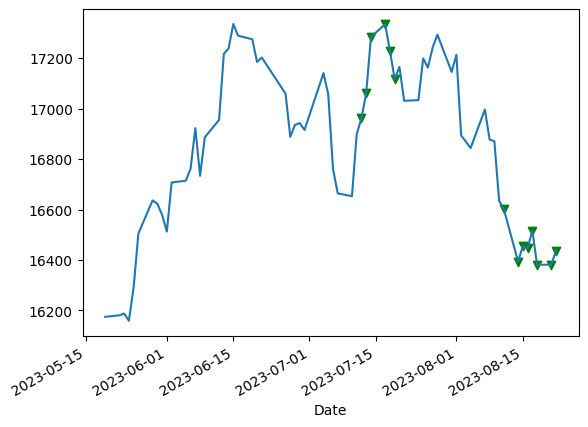

"\nbody = {\n    'to':'U7d64ff0c6e3ddda37825a7d2e5bbc53c',\n    'messages':[{\n            'type': 'text',\n            'text': message2,\n        }]\n    }\n# 向指定網址發送 request\nreq = requests.request('POST', 'https://api.line.me/v2/bot/message/push',headers=headers,data=json.dumps(body).encode('utf-8'))\n"

In [ ]:
#此份檔案程式碼主要架構參考自chatgpt:https://sharegpt.com/c/kZOYTX1
'''
幫我寫一個程式功能如下:
有一個函數叫send_to_telegram(message)用來發送message
有一個函數叫process(df,min_max_scaler,model)用來根據輸入的參數產生交易信號
有一個函數叫main()此做幾件事情:
1.載入model.h5模型
2.載入scaler.pkl
3.使用yfinance取得最近180天^TWII資料稱為df
4.套用process(df,min_max_scaler,model)取得signal
5.當signal == 0,send_to_telegram('不動作')
6.當signal == 1,send_to_telegram('買進')
7.當signal == 2,send_to_telegram('賣出')

使用schedule套件讓這個程式每天早上8點執行一次
'''
import yfinance as yf
from finta import TA
from keras.models import load_model
import pickle
import datetime as dt
import requests, json
import schedule
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 計算金融技術指標函數
def calculate_ta(df):
    ta_functions = [TA.SMA, TA.EMA, TA.STOCH, TA.TEMA, TA.STOCHD, TA.RSI, TA.STOCHRSI, TA.OBV, TA.MACD, TA.PPO, TA.ROC, TA.DMI, TA.ADX, TA.ATR, TA.MOM]
    ta_names = ['SMA','EMA','K','TEMA','D','RSI','STOCHRSI','OBV','MACD','PPO','ROC','DMI','ADX','ATR','MOM']
    for i, ta_func in enumerate(ta_functions):
        try:
            df[ta_names[i]] = ta_func(df)
        except:
            if ta_names[i] == 'MACD':
                df[ta_names[i]] = ta_func(df)['MACD']-ta_func(df)['SIGNAL']
            if ta_names[i] == 'PPO':
                df[ta_names[i]] = ta_func(df)['PPO']-ta_func(df)['SIGNAL']
            if ta_names[i] == 'DMI':
                df[ta_names[i]] = ta_func(df)['DI+']-ta_func(df)['DI-']
    return df

# 給定歷史數據,scaler,model,輸出買賣訊號的函數
def process(df,min_max_scaler,model):
    df = calculate_ta(df)
    df = df.dropna(axis=0)
    features = ['SMA','EMA','K','TEMA','D','RSI','STOCHRSI','OBV','MACD','PPO','ROC','DMI','ADX','ATR','MOM']
    Close = df[['Close']]
    df = df[features]
    # 數據轉換
    df[features] = min_max_scaler.transform(df[features])
    # 製作X(15x15's array)
    days = 15
    start_index = 0
    end_index = len(df)-days
    Xs = []
    indexs = []
    for i in tqdm(range(start_index ,end_index+1 ,1)):
        X = df.iloc[i:i+days,:][features]
        X = np.array(X)
        Xs.append(X)
        indexs.append((df.iloc[[i]].index,df.iloc[[i+days-1]].index))
    Xs = np.array(Xs)
    # 模型預測買賣訊號
    singal = model.predict(Xs)
    singal = [ np.argmax(i) for i in singal]

    # 繪圖
    Close = Close.iloc[-len(Xs):,:]
    Close['SIGNAL'] = singal
    buy = Close[Close['SIGNAL']==1]['Close']
    sell = Close[Close['SIGNAL']==2]['Close']

    Close['Close'].plot()
    plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
    plt.show()

    Close['Close'].plot()
    plt.scatter(list(sell.index),list(sell.values),color='green',marker='v')
    plt.show()

    return singal, Close.index


# 載入模型和scaler
model = load_model('/content/drive/MyDrive/ChatGPT-AI-InvestmentAdvisor/model_2_2.h5')
with open('/content/drive/MyDrive/ChatGPT-AI-InvestmentAdvisor/scaler2_2.pkl', 'rb') as f:
    min_max_scaler = pickle.load(f)
# 資料時間範圍設定
start_date = (dt.datetime.now() - dt.timedelta(days=180)).strftime("%Y-%m-%d")
end_date = dt.datetime.now().strftime("%Y-%m-%d")
symbol = '^TWII'
df = yf.download(symbol, start=start_date, end=end_date)
# 取得交易訊號
signals, index = process(df,min_max_scaler,model)
signal = signals[-1]
if signal == 0:
    action = '不動作'
if signal == 1:
    action = '建議買入'
if signal == 2:
    action = '建議賣出'

capital = 1000000  # 初始資本
hold = False  # 是否持有股票
entry_price = 0  # 進場價格
entry_idx = 0  # 進場時間點
exit_price = 0  # 出場價格
exit_idx = 0  # 出場時間點
t = 20
lb = 0.97
ub = 1.03
capital_history = []
for i, signal in enumerate(signals):
    if signal == 1 and not hold:  # 進場買入
        hold = True
        entry_price = df.iloc[i]['Close']
        entry_idx = i
    elif signal == 2 and hold:  # 出場賣出
        hold = False
        exit_price = df.iloc[i]['Close']
        exit_idx = i
        # 計算交易結果
        shares = capital // entry_price
        profit = shares * (exit_price - entry_price)
        capital += profit
    elif hold and (i - entry_idx >= t or df.iloc[i]['Close'] <= entry_price * lb or df.iloc[i]['Close'] >= entry_price * ub):  # 到達出場條件
        hold = False
        exit_price = df.iloc[i]['Close']
        exit_idx = i
        # 計算交易結果
        shares = capital // entry_price
        profit = shares * (exit_price - entry_price)
        capital += profit
    capital_history.append(capital)

# 發送消息至telegram
current_time = dt.datetime.now().strftime("%Y-%m-%d")
message = f"現在時間:{current_time} 投資項目:{symbol} 當前建議操作:{action}"
message2 = f"累積報酬率:+{(capital_history[-1]/capital_history[0]-1)*100:0.3f}% 目前最大虧損:{-(1-min(capital_history)/capital_history[0])*100:0.3f}%"

# 發送消息至line
access_token = 'Bearer c6Zhd7ahP1ef5rjhTjzkUV093RI+d3MWfg0+yoyM9Xj712a6HG31U1ftXIYS9Bun1SAfos1VgpuMTLmoI7ngMQKrkLqLm6XE7eYr8qqZxn5LvgJ1VIKBqkxDRLi/KYoDgrsKZoPEH2KSqsbqoro0/AdB04t89/1O/w1cDnyilFU='
secret = '4c64ab99437ed50529c461dc95bf8b95'

# 注意前方要有 Bearer
headers = {'Authorization': access_token,'Content-Type':'application/json'}
body = {
    'to':'U7d64ff0c6e3ddda37825a7d2e5bbc53c',
    'messages':[{
            'type': 'text',
            'text': message,
        }]
    }
# 向指定網址發送 request
req = requests.request('POST', 'https://api.line.me/v2/bot/message/push',headers=headers,data=json.dumps(body).encode('utf-8'))
'''
body = {
    'to':'U7d64ff0c6e3ddda37825a7d2e5bbc53c',
    'messages':[{
            'type': 'text',
            'text': message2,
        }]
    }
# 向指定網址發送 request
req = requests.request('POST', 'https://api.line.me/v2/bot/message/push',headers=headers,data=json.dumps(body).encode('utf-8'))
'''

In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask, request

# 載入 LINE Message API 相關函式庫
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import MessageEvent, TextMessage, TextSendMessage

# 載入 json 標準函式庫，處理回傳的資料格式
import json

app = Flask(__name__)


@app.route("/", methods=['POST'])
def linebot():
    body = request.get_data(as_text=True)                    # 取得收到的訊息內容
    try:
        json_data = json.loads(body)                         # json 格式化訊息內容
        access_token = 'c6Zhd7ahP1ef5rjhTjzkUV093RI+d3MWfg0+yoyM9Xj712a6HG31U1ftXIYS9Bun1SAfos1VgpuMTLmoI7ngMQKrkLqLm6XE7eYr8qqZxn5LvgJ1VIKBqkxDRLi/KYoDgrsKZoPEH2KSqsbqoro0/AdB04t89/1O/w1cDnyilFU='
        secret = '4c64ab99437ed50529c461dc95bf8b95'
        line_bot_api = LineBotApi(access_token)              # 確認 token 是否正確
        handler = WebhookHandler(secret)                     # 確認 secret 是否正確
        signature = request.headers['X-Line-Signature']      # 加入回傳的 headers
        handler.handle(body, signature)                      # 綁定訊息回傳的相關資訊

        tk = json_data['events'][0]['replyToken']            # 取得回傳訊息的 Token

        if json_data['events'][0]['message']['text'] == '查看':
        # 取得 LINE 收到的文字訊息
          msg2 = message2
        else:
          msg2 = json_data['events'][0]['message']['text']
        line_bot_api.reply_message(tk,TextSendMessage(msg2))  # 回傳訊息
        print(msg2, tk)                                       # 印出內容
    except:
        print(body)                                          # 如果發生錯誤，印出收到的內容
    return 'OK'                 # 驗證 Webhook 使用，不能省略
if __name__ == "__main__":
  run_with_ngrok(app)           # 串連 ngrok 服務
  app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://c83e-34-136-239-162.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


<ipython-input-9-f37a3a0a4892>:22: LineBotSdkDeprecatedIn30: Call to deprecated class LineBotApi. (Use v3 class; linebot.v3.<feature>. See https://github.com/line/line-bot-sdk-python/blob/master/README.rst for more details.) -- Deprecated since version 3.0.0.
  line_bot_api = LineBotApi(access_token)              # 確認 token 是否正確
<ipython-input-9-f37a3a0a4892>:23: LineBotSdkDeprecatedIn30: Call to deprecated class WebhookHandler. (Use 'from linebot.v3.webhook import WebhookHandler' instead. See https://github.com/line/line-bot-sdk-python/blob/master/README.rst for more details.) -- Deprecated since version 3.0.0.
  handler = WebhookHandler(secret)                     # 確認 secret 是否正確
INFO:werkzeug:127.0.0.1 - - [23/Aug/2023 03:40:56] "POST / HTTP/1.1" 200 -


{"destination":"U400a6028ce7cc7d774e721a39dbaab50","events":[]}


<ipython-input-9-f37a3a0a4892>:34: LineBotSdkDeprecatedIn30: Call to deprecated method reply_message. (Use 'from linebot.v3.messaging import MessagingApi' and 'MessagingApi(...).reply_message(...)' instead. See https://github.com/line/line-bot-sdk-python/blob/master/README.rst for more details.) -- Deprecated since version 3.0.0.
  line_bot_api.reply_message(tk,TextSendMessage(msg2))  # 回傳訊息
INFO:werkzeug:127.0.0.1 - - [23/Aug/2023 03:41:18] "POST / HTTP/1.1" 200 -


累積報酬率:+3.761% 目前最大虧損:-0.000% 0d8414e0f7f54704adf695b290ef0655


INFO:werkzeug:127.0.0.1 - - [23/Aug/2023 03:41:30] "POST / HTTP/1.1" 200 -


買入 3db39bd0a7a24c56b4bf22eee035c03f


INFO:werkzeug:127.0.0.1 - - [23/Aug/2023 03:41:40] "POST / HTTP/1.1" 200 -


累積報酬率:+3.761% 目前最大虧損:-0.000% 6172e518c7924bfa902c9e78970fe854
